In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc03s

Data load and region parameters

In [3]:
name = 'CarB'

In [4]:
reg = 'CarB'

In [5]:
pickle_in = open('SFresults//' + name + '.pkl',"rb")
SFresults = pickle.load(pickle_in)

In [6]:
B = SFresults['b2']
r = SFresults['s']
s0 = SFresults['s0']*2.355      
m = SFresults['m'] 
sig2 = SFresults['sig2'] 
r0 = SFresults['r0'] 
noise = B.mean()*0.1

In [7]:
model02 = lmfit.Model(bfunc03s)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [8]:
relative_uncertainty = 0.25
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 3.0

In [9]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=0.2)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [10]:
result2 = model02.fit(
    B, 
    weights=weights,
    r = r, r0 = r0, m = m, s0 = s0, noise = noise, sig2=sig2,
)

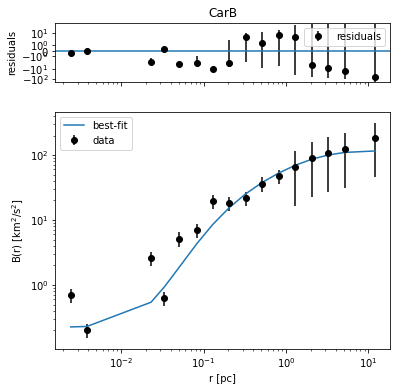

In [11]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title=reg,
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

plt.savefig('Imgs//SF//' + reg + '.pdf', bbox_inches='tight')



In [12]:
CIresults = {'resultCI' : result2,
            'Rmax/r0' : r.max()/result2.params['r0'].value,
            'lT' : (r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))
          }

In [13]:
f = open('CIresults//' + name +'.pkl',"wb")
pickle.dump(CIresults,f)
f.close()

In [14]:
print(result2.fit_report())

[[Model]]
    Model(bfunc03s)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 146
    # data points      = 16
    # variables        = 5
    chi-square         = 36.9150885
    reduced chi-square = 3.35591713
    Akaike info crit   = 23.3765063
    Bayesian info crit = 27.2394500
[[Variables]]
    r0:     0.87669665 +/- 2.31636474 (264.22%) (init = 1.244282)
    sig2:   58.9340886 +/- 91.3290194 (154.97%) (init = 64.19082)
    m:      0.82398921 +/- 1.61144575 (195.57%) (init = 1.2)
    s0:     0.05838992 +/- 0.21333612 (365.36%) (init = 0.009293878)
    noise:  0.22482921 +/- 0.09044519 (40.23%) (init = 4.562699)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, s0)       = -0.989
    C(r0, sig2)    =  0.984
    C(sig2, m)     = -0.747
    C(r0, m)       = -0.718
    C(sig2, s0)    =  0.687
    C(r0, s0)      =  0.641
    C(m, noise)    =  0.155
    C(r0, noise)   = -0.146
    C(sig2, noise) = -0.133
    C(s0, noise)   = -0.121


In [15]:
for p in result2.model.param_names:
    result2.params[p].stderr = result2.params[p].value * 0.1

In [16]:
result2.conf_interval()
print(result2.ci_report())

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=-1.0 < 1e-05 at iteration 9 and prob(r0=0.08766966528932409) = 0.0 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:319: UserWarning: maxiter=200 reached and prob(r0=18.498299376047434) = 0.38636780692795464 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=-1.0 < 1e-05 at iteration 7 and prob(sig2=17.680226580148762) = 0.0 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=-1.0 < 1e-05 at iteration 68 and prob(sig2=459.68589108386794) = 0.0 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:312: UserWarning: Bound reached with prob(m=0.0) = 0.8547697894796505 < max(sigmas)
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:32

          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :      -inf      -inf      -inf   0.87670      +inf      +inf      +inf
 sig2 :      -inf      -inf      -inf  58.93409      +inf      +inf      +inf
 m    :      -inf      -inf  -0.56387   0.82399      +inf      +inf      +inf
 s0   :      -inf      -inf      -inf   0.05839      +inf      +inf      +inf
 noise:      -inf  -0.20270  -0.09391   0.22483      +inf      +inf      +inf


C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=-1.0 < 1e-05 at iteration 5 and prob(noise=0.33724381331487363) = 0.0 < max(sigmas).
  warn(errmsg)


plt.style.use([
    "seaborn-poster",
])

plot_limits = {
    "s0": [0.0, 0.1],
    "m": [.5, .5],
    "r0": [0.1, 1.0],
    "noise": [0.0, 0.5],
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('M8')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [17]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 107.44687485694885 seconds ---
